<a href="https://colab.research.google.com/github/scardenol/RP_argos/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and prefs

In [1007]:
import sympy as sp
from sympy import symbols, init_printing, Function, sympify, Derivative, simplify, ordered
init_printing(use_latex='mathjax') # Printing preferences
import numpy as np

import pandas as pd # Modin to use pandas in a multi-core way
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt #gráficas
import matplotlib as mpl
import seaborn as sns #gráficas
plt.style.use('ggplot') #estilo de graficas

# Read Data

In [1008]:
url = 'https://github.com/scardenol/RP_argos/blob/main/cement_data.xlsx?raw=true' # Raw link
data = pd.read_excel(io=url, sheet_name='Sheet1')
data.pop(data.columns[0]);

In [1009]:
data.head(3)

,Fecha,Tipo Cemento,< 3um,3-30 um,>30 um,Blaine,Ret 325,Cons Normal,F Inicial,F Final,Cons Agua,Fluidez,SiO2,Al2O3,Fe2O3,CaO,MgO,SO3,K2O,Na2O,P Ignea,Cal libre,EA,Adición caliza,Tiempo,Resistencia
0,2019-11-04,1,25.49,69.26,5.25,4846.0,1.5,26.77,94.0,190.0,350.0,111.10,19.28,4.5,3.29,62.82,2.91,2.59,0.23,0.31,4.07,1.73,0.46134,0.11284,1,16.96
1,2019-11-04,1,25.49,69.26,5.25,4846.0,1.5,26.77,94.0,190.0,350.0,111.08,19.28,4.5,3.29,62.82,2.91,2.59,0.23,0.31,4.07,1.73,0.46134,0.11334,3,25.59
2,2019-11-04,1,25.49,69.26,5.25,4846.0,1.5,26.77,94.0,190.0,350.0,111.08,19.28,4.5,3.29,62.82,2.91,2.59,0.23,0.31,4.07,1.73,0.46134,0.11334,7,26.44


In [1010]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988 entries, 0 to 2987
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Fecha           2988 non-null   datetime64[ns]
 1   Tipo Cemento    2988 non-null   int64         
 2   < 3um           2988 non-null   float64       
 3   3-30 um         2988 non-null   float64       
 4   >30 um          2988 non-null   float64       
 5   Blaine          2988 non-null   float64       
 6   Ret 325         2988 non-null   float64       
 7   Cons Normal     2988 non-null   float64       
 8   F Inicial       2988 non-null   float64       
 9   F Final         2988 non-null   float64       
 10  Cons Agua       2988 non-null   float64       
 11  Fluidez         2988 non-null   float64       
 12  SiO2            2988 non-null   float64       
 13  Al2O3           2988 non-null   float64       
 14  Fe2O3           2988 non-null   float64       
 15  CaO 

In [1011]:
data.describe()

,Tipo Cemento,< 3um,3-30 um,>30 um,Blaine,Ret 325,Cons Normal,F Inicial,F Final,Cons Agua,Fluidez,SiO2,Al2O3,Fe2O3,CaO,MgO,SO3,K2O,Na2O,P Ignea,Cal libre,EA,Adición caliza,Tiempo,Resistencia
count,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000
mean,0.879853,21.784587,71.741754,6.398763,4756.762125,0.995865,26.759882,112.104247,216.878226,354.890044,110.211673,20.133334,4.502215,3.057305,62.560509,2.435672,2.691496,0.204898,0.108033,4.117379,1.092806,0.242816,0.090984,9.768742,33.334146
std,0.325188,2.691147,4.352730,2.132732,320.432091,0.729051,0.697346,19.706644,23.518137,5.770927,2.750848,0.506143,0.147388,0.164173,0.831426,0.294099,0.252173,0.027271,0.095993,0.832241,0.319576,0.104367,0.036096,10.765467,11.475799
min,0.000000,2.280000,7.700000,0.000000,3915.000000,0.090000,24.770000,62.000000,117.000000,340.000000,105.000000,18.760000,4.100000,2.120000,59.690000,1.840000,1.890000,0.020000,0.000000,1.410000,0.480000,0.066320,0.020000,1.000000,3.010000
25%,1.000000,20.250000,69.417500,5.210000,4520.000000,0.270000,26.310000,100.000000,200.000000,352.000000,108.000000,19.837500,4.410000,2.950000,62.090000,2.240000,2.540000,0.190000,0.050000,3.620000,0.890000,0.175020,0.070000,3.000000,24.047500
50%,1.000000,22.120000,71.668350,6.288700,4730.000000,0.940000,26.770000,111.000000,220.000000,354.000000,110.460000,20.210000,4.520000,3.040000,62.600000,2.390000,2.690000,0.200000,0.060000,4.140000,1.030000,0.194760,0.090000,7.000000,33.800000
75%,1.000000,23.280000,74.290000,7.240000,4969.000000,1.610000,27.230000,124.000000,230.000000,357.000000,112.000000,20.450000,4.610000,3.170000,63.070000,2.580000,2.820000,0.220000,0.140000,4.730000,1.210000,0.287920,0.106250,28.000000,43.097500
max,1.000000,31.910000,92.020000,28.330000,6041.000000,2.910000,31.380000,172.000000,330.000000,380.000000,115.000000,22.030000,4.880000,3.880000,67.270000,3.550000,3.790000,0.280000,0.950000,6.840000,2.460000,1.081600,0.400000,28.000000,57.630000


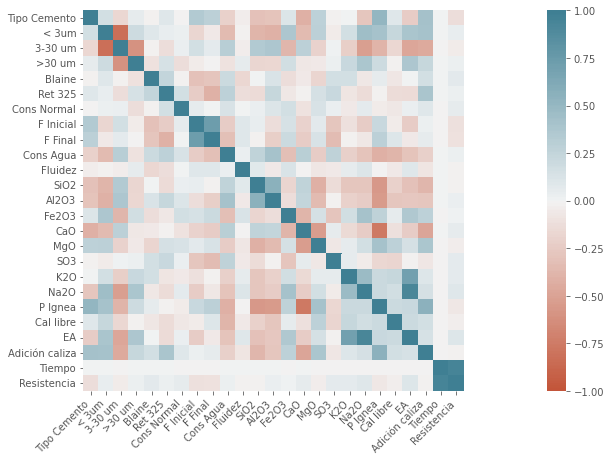

In [1012]:
plt.figure(figsize = (30, 7))

corr = data.corr(method = 'spearman')
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [1013]:
corr['Resistencia'].sort_values()

Tipo Cemento     -0.120514
F Inicial        -0.115945
F Final          -0.106363
P Ignea          -0.067376
3-30 um          -0.046401
MgO              -0.037976
Cal libre        -0.024407
Adición caliza   -0.016970
Fluidez          -0.010661
SiO2             -0.010151
Fe2O3             0.010001
>30 um            0.025217
Cons Agua         0.028711
Ret 325           0.029028
Al2O3             0.034823
< 3um             0.045486
CaO               0.050709
Cons Normal       0.060971
K2O               0.063065
SO3               0.068290
Blaine            0.070475
Na2O              0.100843
EA                0.107117
Tiempo            0.950424
Resistencia       1.000000
Name: Resistencia, dtype: float64

In [1014]:
data.loc[:, 'Tipo Cemento'] = data['Tipo Cemento'].map(lambda s:'UEM' if s == 1 else 'IND') # Cement type map: {0,1} -> {IND, UEM}

In [1015]:
data.groupby(['Tipo Cemento']).size() # Samples per cement type

Tipo Cemento
IND     359
UEM    2629
dtype: int64

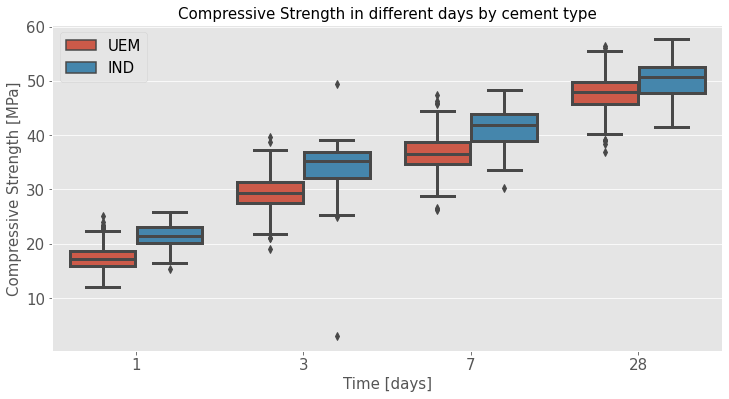

In [1016]:
plt.figure(figsize = (12, 6));
sns.boxplot(x= 'Tiempo', y = 'Resistencia', data = data, hue = 'Tipo Cemento', linewidth = 3);
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
plt.xlabel('Time [days]', fontsize = 15);
plt.ylabel('Compressive Strength [MPa]', fontsize = 15);
plt.legend(fontsize = 15);
plt.title('Compressive Strength in different days by cement type', fontsize = 15);

In [1017]:
data_UEM = data[data['Tipo Cemento'] == 'UEM'].reset_index(drop=True) # Retrieval of UEM sample
data_UEM.head(3)

,Fecha,Tipo Cemento,< 3um,3-30 um,>30 um,Blaine,Ret 325,Cons Normal,F Inicial,F Final,Cons Agua,Fluidez,SiO2,Al2O3,Fe2O3,CaO,MgO,SO3,K2O,Na2O,P Ignea,Cal libre,EA,Adición caliza,Tiempo,Resistencia
0,2019-11-04,UEM,25.49,69.26,5.25,4846.0,1.5,26.77,94.0,190.0,350.0,111.10,19.28,4.5,3.29,62.82,2.91,2.59,0.23,0.31,4.07,1.73,0.46134,0.11284,1,16.96
1,2019-11-04,UEM,25.49,69.26,5.25,4846.0,1.5,26.77,94.0,190.0,350.0,111.08,19.28,4.5,3.29,62.82,2.91,2.59,0.23,0.31,4.07,1.73,0.46134,0.11334,3,25.59
2,2019-11-04,UEM,25.49,69.26,5.25,4846.0,1.5,26.77,94.0,190.0,350.0,111.08,19.28,4.5,3.29,62.82,2.91,2.59,0.23,0.31,4.07,1.73,0.46134,0.11334,7,26.44


In [1018]:
# X = data_UEM.iloc[:,2:-1] # Ignore first 2 columns and last column to get predictors (x1, x2, ..., xn)
training_data = data_UEM.sample(frac=0.1, random_state=25) # frac = proportion, random_state = seed
testing_data = data_UEM.drop(training_data.index)

In [1019]:
# Retrieve X and Y data for training
# X_training = training_data[['Tiempo', 'EA', 'Na2O', 'F Inicial', 'P Ignea']] # Retrieve the predictors x1, x2, ..., xn
X_training = training_data[['Tiempo', 'EA', 'F Inicial']]
Y_training = training_data['Resistencia'] # Retrieve the Y variable

# Retrieve X and Y data for testing
# X_testing = training_data[['Tiempo', 'EA', 'Na2O', 'F Inicial', 'P Ignea']] # Retrieve the predictors x1, x2, ..., xn
X_testing = testing_data[['Tiempo', 'EA', 'F Inicial']]
Y_testing = training_data['Resistencia'] # Retrieve the Y variable

In [1020]:
# Convert training X and Y to lists
X_training_list = [X_training.iloc[:,i].tolist() for i in range(X_training.shape[1])]
Y_training_list = Y_training.iloc[:].tolist()

# Convert testing X and Y to lists
X_training_list = [X_training.iloc[:,i].tolist() for i in range(X_training.shape[1])]
Y_training_list = Y_training.iloc[:].tolist()

# Model

## Functions

In [1021]:
def Taylor_polynomial_sympy(function_expression, variable_list, evaluation_point, degree):
  """
  Mathematical formulation reference:
  https://math.libretexts.org/Bookshelves/Calculus/Supplemental_Modules_(Calculus)/Multivariable_Calculus/3%3A_Topics_in_Partial_Derivatives/Taylor__Polynomials_of_Functions_of_Two_Variables
  :param function_expression: Sympy expression of the function
  :param variable_list: list. All variables to be approximated (to be "Taylorized")
  :param evaluation_point: list. Coordinates, where the function will be expressed
  :param degree: int. Total degree of the Taylor polynomial
  :return: Returns a Sympy expression of the Taylor series up to a given degree, of a given multivariate expression, approximated as a multivariate polynomial evaluated at the evaluation_point
  """
  from sympy import factorial, Matrix, prod
  import itertools

  n_var = len(variable_list)
  point_coordinates = [(i, j) for i, j in (zip(variable_list, evaluation_point))]  # list of tuples with variables and their evaluation_point coordinates, to later perform substitution

  deriv_orders = list(itertools.product(range(degree + 1), repeat=n_var))  # list with exponentials of the partial derivatives
  deriv_orders = [deriv_orders[i] for i in range(len(deriv_orders)) if sum(deriv_orders[i]) <= degree]  # Discarding some higher-order terms
  n_terms = len(deriv_orders)
  deriv_orders_as_input = [list(sum(list(zip(variable_list, deriv_orders[i])), ())) for i in range(n_terms)]  # Individual degree of each partial derivative, of each term

  polynomial = 0
  for i in range(n_terms):
    partial_derivatives_at_point = function_expression.diff(*deriv_orders_as_input[i]).subs(point_coordinates)  # e.g. df/(dx*dy**2)
    denominator = prod([factorial(j) for j in deriv_orders[i]])  # e.g. (1! * 2!)
    distances_powered = prod([(Matrix(variable_list) - Matrix(evaluation_point))[j] ** deriv_orders[i][j] for j in range(n_var)])  # e.g. (x-x0)*(y-y0)**2
    polynomial += partial_derivatives_at_point / denominator * distances_powered
  return polynomial

In [1022]:
def Model_taylor_sympy(taylor_serie):
  """
  param taylor_serie: taylor serie to be converted to model
  return: list of model termns
  """
  from sympy import symbols, init_printing, Function, sympify, Derivative, simplify, ordered

  # Convert Serie to list
  S = list(sympify((sympify(taylor_serie, evaluate=False)).args))
  M = S.copy() # Copy the list to use for the model

  # Check for derivatives
  # Substitue derivatives from Serie List with parameters (cleaner than from Serie)
  d = [list(i.atoms(Derivative)) for i in M]
  d_unpacked = [x for l in d for x in l] # this unpacks it but gets messy if a list had more than 1 element
  
  # if d_unpacked is empty it means there are no derivatives in the serie
  B = [];

  if len(d_unpacked) != 0:  # if there are derivatives
    indexes = [idx for idx in range(len(d)) if len(d[idx])] # Get indexes

    for i in indexes:
      B_aux = sympify(['b' + str(b) for b in range(len(B), len(B) + 1)])
      B += B_aux
      M[i] = simplify(M[i].subs(list(ordered(d[i]))[0], B_aux[0]))
    
    # Clean the f(c) termn at the end
    B_aux = sympify(['b' + str(b) for b in range(len(B), len(B) + 1)])
    B += B_aux
    M[-1] = B_aux[0]

    # Multiply resulting list with the parameter list A (excluding the last element which has only 1 parameter)
    A = sympify(['a' + str(a) for a in range(0, len(B)-1)])
    M = [a*m for a,m in zip(A,M[:-1])] + [M[-1]]
  
  else: # If there are not derivatives
    # Multiply resulting list with the parameter list A
    A = sympify(['a' + str(a) for a in range(0, len(M))])
    M = [a*m for a,m in zip(A,M)]
  
  return M, A, B

## Implementation

In [1023]:
# Model F(x1, x2, ..., xn) where n is n_vars
# x1, x2, x3 = symbols('x1, x2, x3')
# n_vars = 3
n_vars = X_training.shape[1] # Num of variables = num of columns
variable_list = list(range(1,n_vars+1)) # List of variable indexes
variable_list = [symbols('x' + str(i)) for i in variable_list] # List of symbolic variables
f = Function('f')
# function_expression = f(x1*x2*x3)
# function_expression = f(np.prod(variable_list))
function_expression = f(sum(variable_list))
# variable_list = [x1,x2,x3]
# evaluation_point = [1, 2, 3]
evaluation_point = [0]*n_vars # Every x is centered at 0
degree=2
F = Taylor_polynomial_sympy(function_expression, variable_list, evaluation_point, degree)
# display(F)


In [1024]:
# Generate the model
M, A, B = Model_taylor_sympy(F)

In [1025]:
# Display results
# F_list = list(sympify((sympify(F, evaluate=False)).args))
# display(F_list) # Original
# display(M) # model
# print(len(F_list) == len(M))
# display(A, B) # Parameters
parameters = A + B
display(parameters) # List of all parameters

[a₀, a₁, a₂, a₃, a₄, a₅, a₆, a₇, a₈, b₀, b₁, b₂, b₃, b₄, b₅, b₆, b₇, b₈, b₉]

In [1026]:
# Convert list back to sum
model = sum(M)
display(model)

                                         2           2           2            
                                 a₃⋅b₃⋅x₁    a₄⋅b₄⋅x₂    a₅⋅b₅⋅x₃             
a₀⋅b₀⋅x₁ + a₁⋅b₁⋅x₂ + a₂⋅b₂⋅x₃ + ───────── + ───────── + ───────── + a₆⋅b₆⋅x₁⋅
                                     2           2           2                

                                   
                                   
x₂ + a₇⋅b₇⋅x₁⋅x₃ + a₈⋅b₈⋅x₂⋅x₃ + b₉
                                   

In [1027]:
model2 = model.subs([(i,1) for i in A])
display(model2)

                             2        2        2                              
                        b₃⋅x₁    b₄⋅x₂    b₅⋅x₃                               
b₀⋅x₁ + b₁⋅x₂ + b₂⋅x₃ + ────── + ────── + ────── + b₆⋅x₁⋅x₂ + b₇⋅x₁⋅x₃ + b₈⋅x₂
                          2        2        2                                 

        
        
⋅x₃ + b₉
        

In [1028]:
vars = variable_list + parameters
display(vars) # Order of function parameters
fun = sp.lambdify(vars, model, 'numpy')
# value = [i for i in range(len(vars))]
# fun(*[1]*len(vars))

[x₁, x₂, x₃, a₀, a₁, a₂, a₃, a₄, a₅, a₆, a₇, a₈, b₀, b₁, b₂, b₃, b₄, b₅, b₆, b
₇, b₈, b₉]

In [1029]:
parameters2 = B
vars2 = variable_list + parameters2
display(vars2) # Order of function parameters
fun2 = sp.lambdify(vars2, model2, 'numpy')

[x₁, x₂, x₃, b₀, b₁, b₂, b₃, b₄, b₅, b₆, b₇, b₈, b₉]

# Genetic Algorithm

## Functions

In [1083]:
import numpy as np
import random

"""
Based on the simple (non-vectorial) GA from https://towardsdatascience.com/genetic-algorithm-implementation-in-python-5ab67bb124a6
"""

def mse(A,B): # Cleanest way to calculate Mean Square Error
  return np.square(np.subtract(A, B)).mean()

def cal_pop_fitness(equation_inputs, pop, Y, fun):
    # Calculating the fitness value of each solution in the current population.
    # The fitness function calulates the sum of products between each input and its corresponding weight.
    Y_bar = [[fun(*[item[i] for item in equation_inputs], *pop[j]) for i in range(len(equation_inputs[0]))] for j in range(len(pop))]
    fitness = [mse(Y_bar[i], Y) for i in range(len(Y))]
    return np.array(fitness)

def select_mating_pool(pop, fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        min_fitness_idx = np.where(fitness == np.min(fitness))
        min_fitness_idx = min_fitness_idx[0][0]
        parents[parent_num, :] = pop[min_fitness_idx, :]
        fitness[min_fitness_idx] = float('inf') # inf for min, -inf for max
    return parents

def crossover(parents, offspring_size): # Two point crossover
    offspring = np.empty(offspring_size)
    # The point at which crossover takes place between two parents. Usually, it is at the center.
    # crossover_point = np.uint8(offspring_size[1]/2)
    crossover_point = random.randint(0, len(offspring_size)-1)

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring_crossover, prob_mutation, num_mutations=1):
    mutations_counter = np.uint8(offspring_crossover.shape[1] / num_mutations)
    # Mutation changes a number of genes as defined by the num_mutations argument. The changes are random.
    for idx in range(offspring_crossover.shape[0]):
        gene_idx = mutations_counter - 1
        for mutation_num in range(num_mutations):
            # The random value to be added to the gene.
            random_value = random.randint(10,1000)*np.random.uniform(-1.0, 1.0, 1) # Uniform mutation
            if random.random() < prob_mutation:
              offspring_crossover[idx, gene_idx] = offspring_crossover[idx, gene_idx] * random_value
              gene_idx = gene_idx + mutations_counter
    return offspring_crossover

In [1084]:
def GA(y, N, equation_inputs, num_weights, Y, sol_per_pop, num_parents_mating,
       prob_mutation, pop_size, new_population, tolerance, search_time):
  
  num_generations = 0
  fitness = float('Inf')

  import time
  start = time.time()
  timeout = start + 60*search_time  # search_time minutes from now

  while fitness > tolerance and time.time() <= timeout:
    generation = num_generations
    num_generations += 1
    # proportion = (generation+1)/num_generations # (0,1]
    # num_parents_mating = int(proportion*N) # dynamic mating proportion (0,N]
    # prob_mutation = num_generations/N # dynamic mutation probability
    
    # Measing the fitness of each chromosome in the population.
    fitness = cal_pop_fitness(equation_inputs, new_population, Y, y)
    # print("Fitness: ", fitness)
    # Selecting the best parents in the population for mating.
    parents = select_mating_pool(new_population, fitness, 
                                      num_parents_mating)

    # Generating next generation using crossover.
    offspring_crossover = crossover(parents, 
                                    offspring_size=(pop_size[0]-parents.shape[0], num_weights))

    # Adding some variations to the offsrping using mutation.
    offspring_mutation = mutation(offspring_crossover, prob_mutation)

    # Creating the new population based on the parents and offspring.
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation

    # The best result in the current iteration.
    fitness = np.min(cal_pop_fitness(equation_inputs, new_population, Y, y))
    current_time = time.time()-start
    minutes = round((current_time // 60) % 60, 0)
    seconds = round(current_time % 60, 0)
    print("Generation : ", generation)
    print("Best result : ", fitness, ", Time : ", int(minutes), "m", int(seconds), "s")
    
  # Getting the best solution after iterating finishing all generations.
  #At first, the fitness is calculated for each solution in the final generation.
  fitness = cal_pop_fitness(equation_inputs, new_population, Y, y)
  # Then return the index of that solution corresponding to the best fitness.
  best_match_idx = np.where(fitness == np.min(fitness))

  best_w = (new_population[best_match_idx, :].tolist())[0][0] # Best solution
  best_fitness = fitness[best_match_idx]

  print("Best solution : ", best_w)
  print("Best solution fitness : ", best_fitness)
    
    
  return best_w, best_fitness

## Implementation

In [1089]:
import numpy
import sympy as sp
# Model (equation)
y = fun2

# Inputs of the equation
N = X_training.shape[0]

equation_inputs = X_training_list

# Observation
Y = Y_training_list

# Number of the weights/parameters we are looking to optimize.
num_weights = len(parameters2)

"""
Genetic algorithm parameters:
    Mating pool size
    Population size
"""
sol_per_pop = 2*N # This has to be >= N
num_parents_mating = int(0.6*N)

prob_mutation = 0.3

# Seed
np.random.seed(42)

# Defining the population size.
pop_size = (sol_per_pop,num_weights) # The population will have sol_per_pop chromosome where each chromosome has num_weights genes.
#Creating the initial population.
# new_population = 10*np.random.uniform(low=-1, high=1, size=pop_size) # multiply by 0.001 to converge to mean
new_population = 0.1*np.random.chisquare(df=1, size=pop_size)
# print(new_population)

tolerance = 1e-3
search_time = 2 # in minutes

In [1090]:
best_w, best_fitness = GA(y, N, equation_inputs, num_weights, Y, sol_per_pop, num_parents_mating,
       prob_mutation, pop_size, new_population, tolerance, search_time)

Generation :  0
Best result :  122.36008631423252 , Time :  0 m 3 s
Generation :  1
Best result :  122.36008631423252 , Time :  0 m 6 s
Generation :  2
Best result :  115.49204033460764 , Time :  0 m 8 s
Generation :  3
Best result :  115.49204033460764 , Time :  0 m 11 s
Generation :  4
Best result :  63.53291334341109 , Time :  0 m 14 s
Generation :  5
Best result :  63.53291334341109 , Time :  0 m 17 s
Generation :  6
Best result :  59.56224407066036 , Time :  0 m 19 s
Generation :  7
Best result :  59.56224407066036 , Time :  0 m 22 s
Generation :  8
Best result :  59.56224407066036 , Time :  0 m 25 s
Generation :  9
Best result :  59.56224407066036 , Time :  0 m 28 s
Generation :  10
Best result :  59.56224407066036 , Time :  0 m 30 s
Generation :  11
Best result :  59.56224407066036 , Time :  0 m 33 s
Generation :  12
Best result :  59.56224407066036 , Time :  0 m 36 s
Generation :  13
Best result :  59.56224407066036 , Time :  0 m 39 s
Generation :  14
Best result :  59.56224407

In [1091]:
A = equation_inputs
Y_bar_GA = [y(*[item[i] for item in A], *best_w) for i in range(len(A[0]))]
# print(Y_bar_GA)
# print(Y)
# print((np.array(Y_bar_GA)-np.array(Y).tolist()))
mse_GA = mse(Y_bar_GA,Y)
# print(mse_GA)

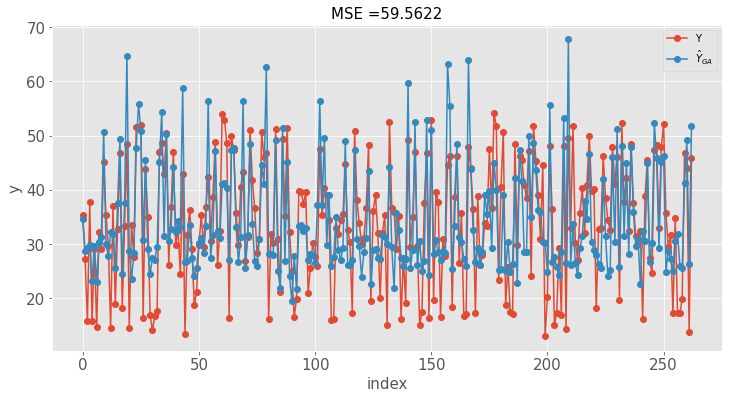

In [1092]:
plt.figure(figsize = (12, 6));
plt.plot(list(range(0,N)), Y, '-o', label='Y')
plt.plot(list(range(0,N)), Y_bar_GA, '-o', label='$\hat{Y}_{GA}$')
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
plt.xlabel('index', fontsize = 15);
plt.ylabel('y', fontsize = 15);
plt.legend()
plt.title('MSE =' + str(round(mse_GA, 4)), fontsize = 15);

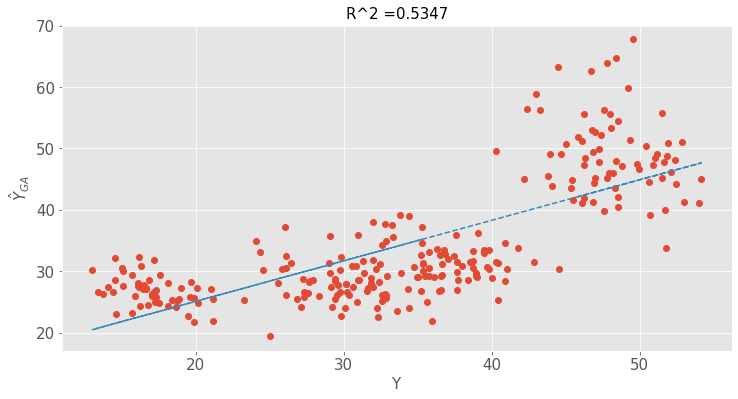

In [1136]:
plt.figure(figsize = (12, 6));
plt.plot(Y, Y_bar_GA, 'o')
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
plt.xlabel('Y', fontsize = 15);
plt.ylabel('$\hat{Y}_{GA}$', fontsize = 15);
RES = sum([(Y[i] - Y_bar_GA[i])**2 for i in range(N)]) # residual error
TOT = sum([(Y[i] - np.mean(Y))**2 for i in range(N)]) # total error
R2 = 1-(RES/TOT) # definition of R2 metric
plt.title('R^2 =' + str(round(R2, 4)), fontsize = 15);

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(Y, Y_bar_GA, 1);

#add linear regression line to scatterplot 
plt.plot(Y, [m*i+b for i in Y], '--');